# Demo network with no spontaneous but successful triggered replay

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport replay.plot
%aimport replay.analysis
from copy import deepcopy as copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from assoc import smln, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.005, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 200, 
    
    # potentiation
    'SGM_MAX': 1.84, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [[(-1, .75), (0, .75), (0, -.75), (1, -.75)]],
    
    'TRG': [
        {'T': .5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
        {'T': 1.5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 2},
}

In [2]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 0

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


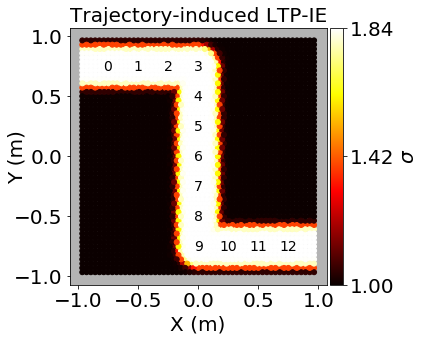

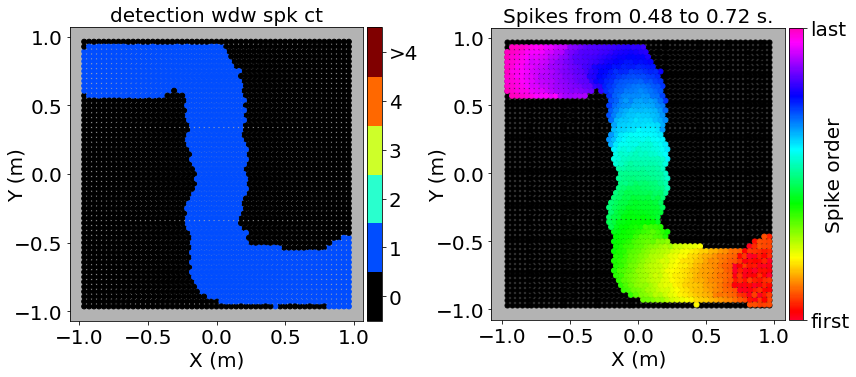

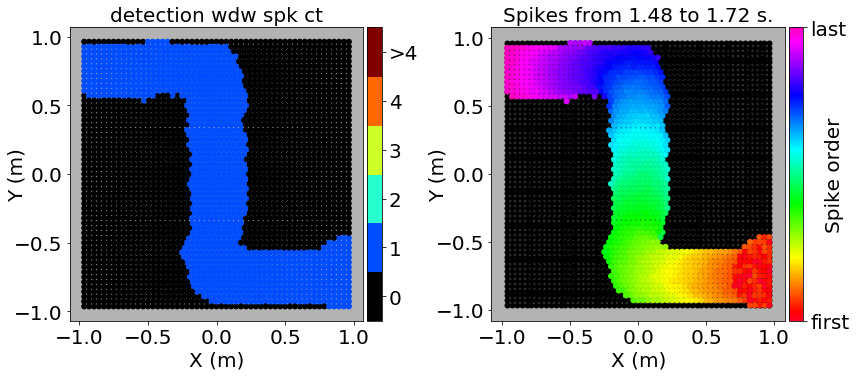

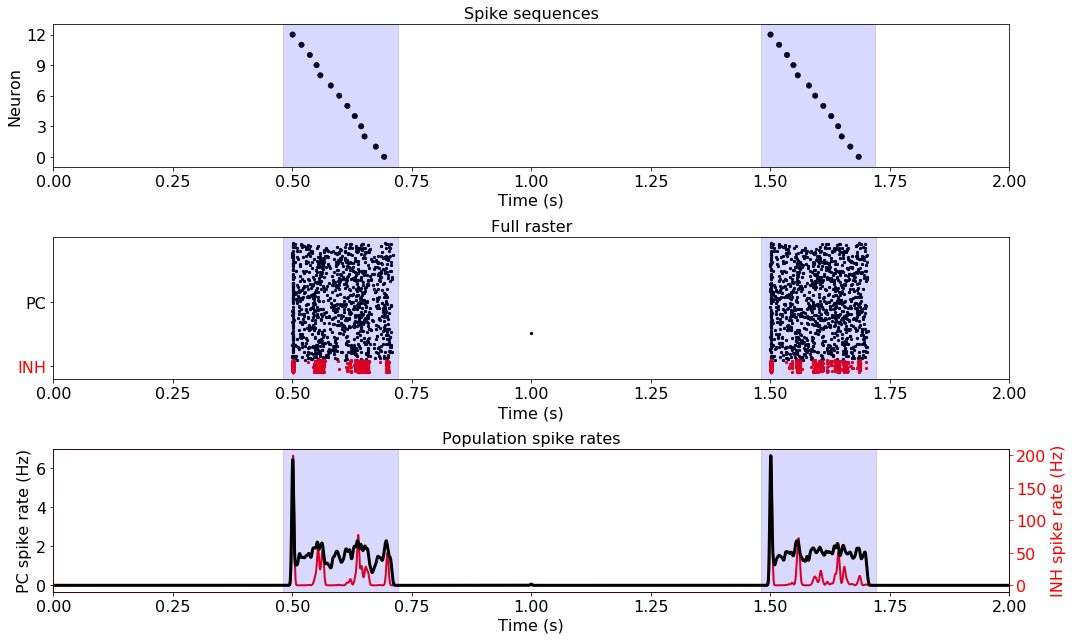

In [3]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.48, .72), (1.48, 1.72)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 2),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)

# Build network with multiple trajecs embedded for associative mapping

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport replay.plot
%aimport replay.analysis
from copy import deepcopy as copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from assoc import smln, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 12000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 1200,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.00003,
    
    # gating inputs
    'W_PC_G': 0.005, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 200, 
    
    # potentiation
    'SGM_MAX': 1.84, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 4, "BOX_W": 4, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2,
    
    'TRJ': [
        [(-1, 1), (1, -1)],
        [(1, 1), (1.75, 1), (1.75, -1.75), (-1, -1.75), (-1, -1)],
    ],
    
    'TRG': [
        {'T': .5, 'A': 0.01, 'R': 0.1, 'D': 0.002, 'X': 1, 'Y': -1},
        {'T': 1.5, 'A': 0.01, 'R': 0.1, 'D': 0.002, 'X': 1, 'Y': 1},
    ],
    
    "schedule": {"D_SMLN": 2},
}

In [2]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 0

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


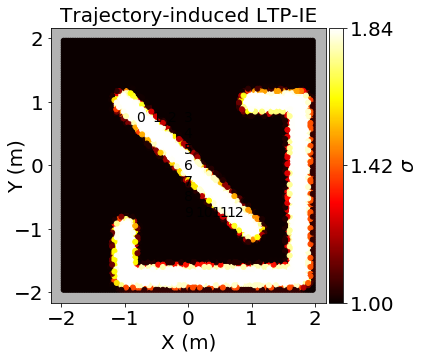

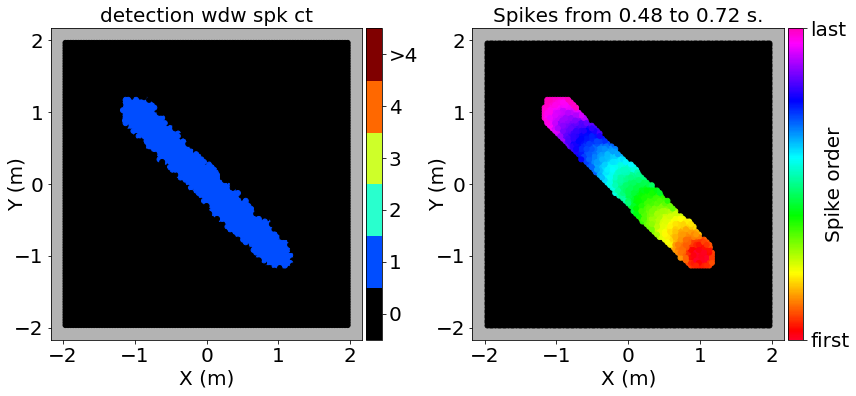

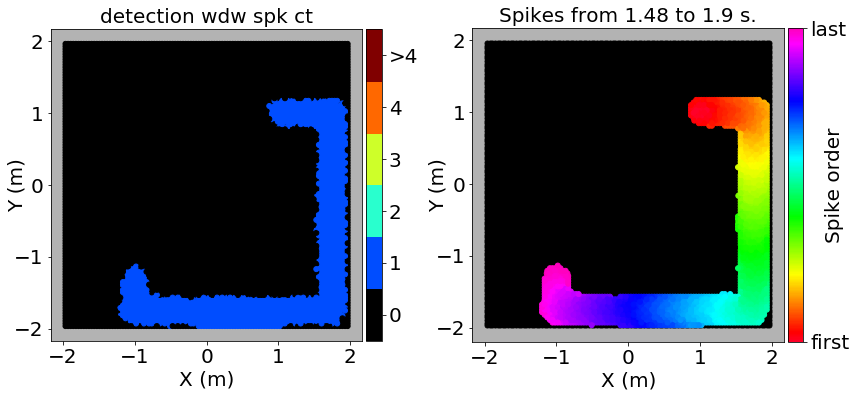

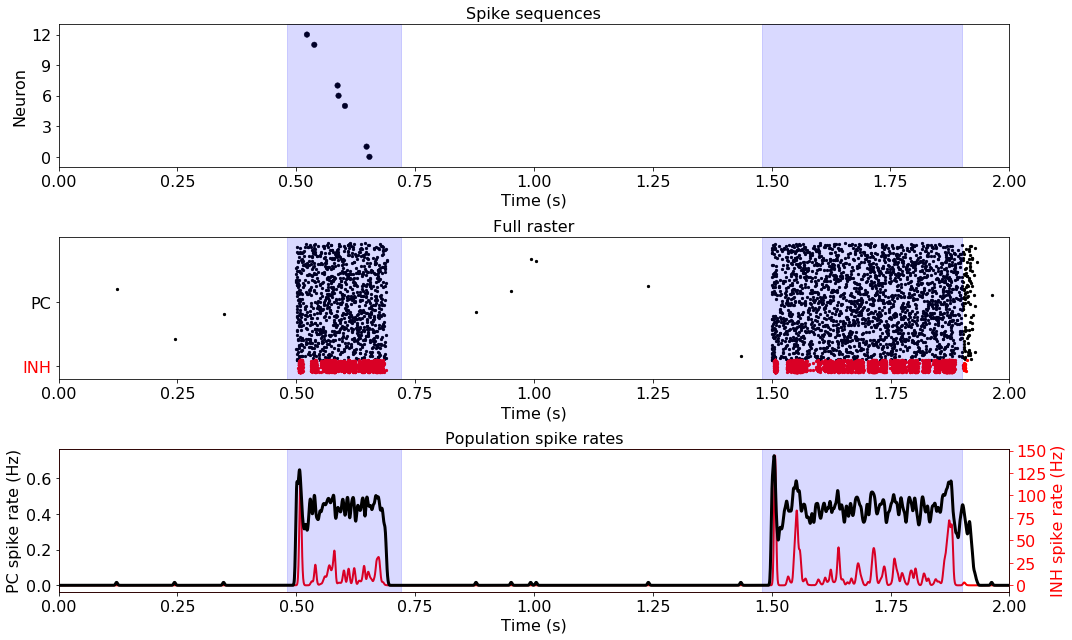

In [3]:
from assoc import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.48, .72), (1.48, 1.9)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 2),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)